# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Dropout regularization in practice
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

C:\sofware\anaconda3\envs\projects\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\rupak\AppData\Local\Temp\ipykernel_11008\2120876513.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create the data

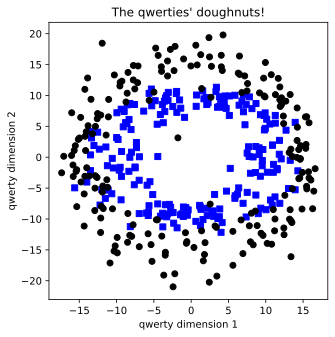

In [2]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Separate the data into DataLoaders

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16 #int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the model

In [4]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # pass the data through the input layer
    x = F.relu( self.input(x) )

    # dropout after input layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    # pass the data through the hidden layer
    x = F.relu( self.hidden(x) )

    # dropout after hidden layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    # output layer
    x = self.output(x)
    # no dropout here!!
    return x

In [5]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.1447],
        [ 0.1487],
        [-0.2495],
        [-0.0948],
        [-0.0928],
        [ 0.0864],
        [-0.0406],
        [ 0.0828],
        [ 0.1524],
        [-0.0486]], grad_fn=<AddmmBackward0>)

# Functions to create and train the net

In [6]:
def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANNQC = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)

  return ANNQC,lossfun,optimizer

In [7]:
# train the model

# training parameter
numepochs = 1000

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch training mode on (is this the right place for this code??)
    ANNQC.train() 

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNQC.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
  
  # function output
  return trainAcc,testAcc


# Test the model

In [8]:
# create a model
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [9]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

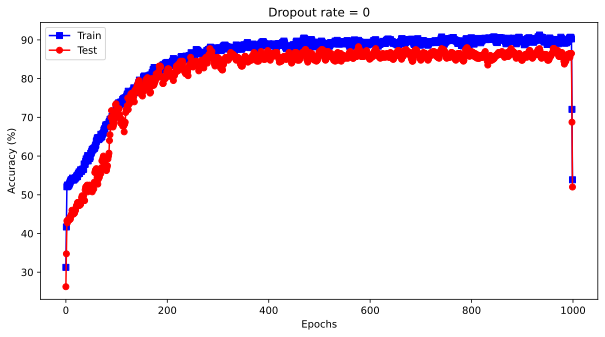

In [10]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

# Now for the experiment!

In [11]:
# run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])


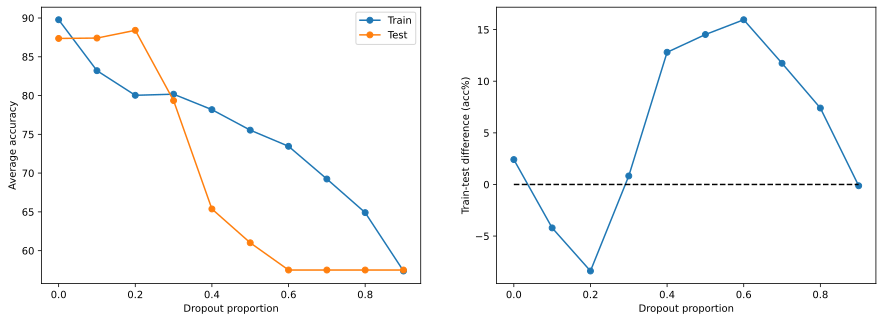

In [12]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Additional explorations

In [13]:
# 1) Explore the effects of the smoothing parameter ('k' in the smooth() function). How much smoothing is "too much"? 
#    Note that this is a subjective judgment; the goal here is to gain some familiarity with smoothing filters.
# 
# 2) Dropout wasn't too impressive here. Perhaps it would be more helpful with a different number of nodes in the hidden
#    layer? Try running the experiment again using half as many hidden nodes, and twice as many nodes. Tip: take screenshots
#    of each result to compare the three runs.
# 